In [1]:
import jax
import jax.numpy as jnp

In [2]:
dim = 3072
seq_len = 8192
base = 10000


In [3]:
inv_freq = 1.0 / (base ** (jnp.arange(0, dim, 2) / dim))

In [9]:
print(1/base**((dim-2)/dim))

0.00010060143292328538


In [10]:
inv_freq[-1]

Array(0.0001006, dtype=float32)

In [12]:
t = jnp.arange(seq_len)
        
# `freqs` is the outer product of positions `t` and frequencies `inv_freq`
# Shape: (max_seq_len, dim / 2)
freqs = jnp.einsum("i,j->ij", t, inv_freq)

In [11]:
freq_cos = jnp.cos(freqs)
freq_sin = jnp.sin(freqs)

freqs_cis = jnp.stack([freq_cos, freq_sin], axis=0)


In [14]:
a = jnp.arange(2*3*4).reshape(2,3,4)
print(a)

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]


In [15]:
a = jnp.repeat(a,2,axis=-1)
print(a)

[[[ 0  0  1  1  2  2  3  3]
  [ 4  4  5  5  6  6  7  7]
  [ 8  8  9  9 10 10 11 11]]

 [[12 12 13 13 14 14 15 15]
  [16 16 17 17 18 18 19 19]
  [20 20 21 21 22 22 23 23]]]


Generating frequency data...
Plotting...
Plot saved successfully to 'rope_scaling_plot_jax.png'


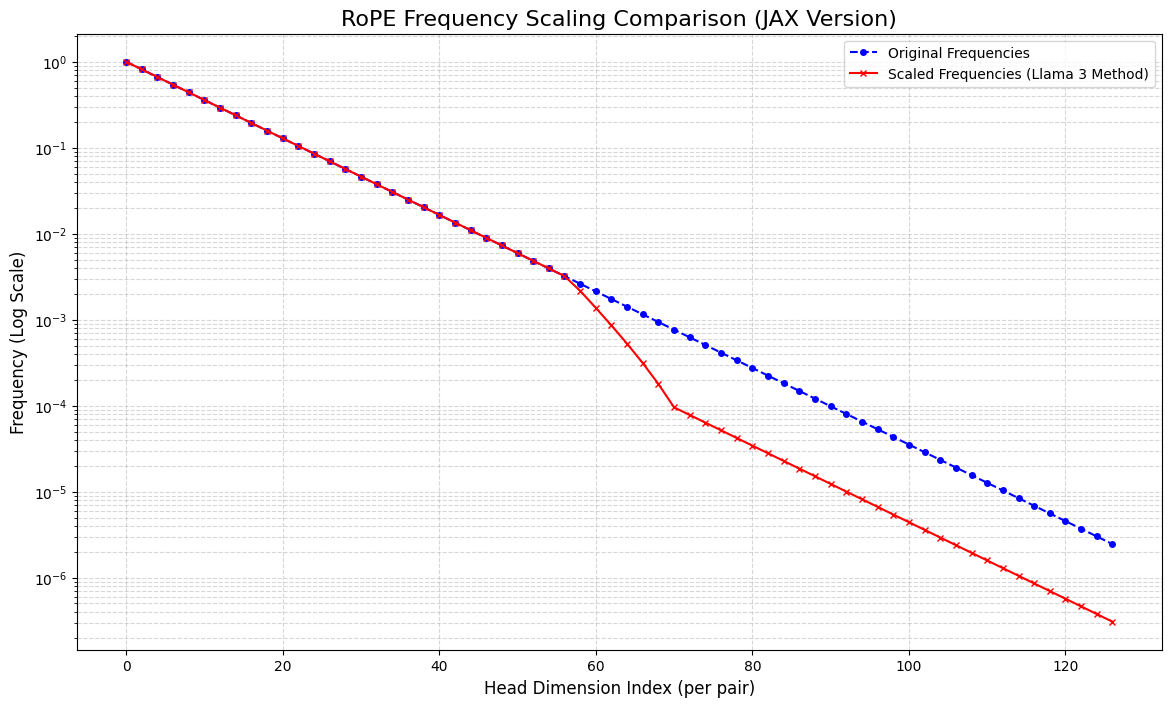

In [18]:
import jax.numpy as jnp
import numpy as np # Matplotlib works best with numpy arrays
import math
import matplotlib.pyplot as plt

# This script visualizes the effect of Llama 3's RoPE scaling on frequencies using JAX.
# Ensure you have JAX and matplotlib installed:
# pip install jax jaxlib matplotlib

# --- Function definitions ---

def apply_scaling(freqs: jnp.ndarray) -> jnp.ndarray:
    """
    Applies the Llama 3 RoPE scaling method to a JAX array of frequencies.
    """
    # RoPE scaling (values obtained from grid search)
    scale_factor = 8
    low_freq_factor = 1
    high_freq_factor = 4
    old_context_len = 8192  # original llama3 length
    low_freq_wavelen = old_context_len / low_freq_factor
    high_freq_wavelen = old_context_len / high_freq_factor
    
    new_freqs = []
    for freq in freqs:
        wavelen = 2 * math.pi / freq
        if wavelen < high_freq_wavelen:
            # High-frequency region: No scaling
            new_freqs.append(freq)
        elif wavelen > low_freq_wavelen:
            # Low-frequency region: Scale down
            new_freqs.append(freq / scale_factor)
        else:
            # Transition region: Smooth interpolation
            assert low_freq_wavelen != high_freq_wavelen
            smooth = (old_context_len / wavelen - low_freq_factor) / (
                high_freq_factor - low_freq_factor
            )
            new_freqs.append((1 - smooth) * freq / scale_factor + smooth * freq)
            
    return jnp.array(new_freqs, dtype=freqs.dtype)

def get_original_freqs(dim: int, theta: float) -> jnp.ndarray:
    """
    Generates the original RoPE frequencies.
    """
    return 1.0 / (theta ** (jnp.arange(0, dim, 2, dtype=jnp.float32) / dim))

# --- Plotting script ---

def plot_freq_scaling(head_dim: int, theta: float):
    """
    Generates and plots the original vs. scaled RoPE frequencies using JAX,
    then saves the plot to a file.
    """
    print("Generating frequency data...")
    # 1. Get original frequencies
    original_freqs = get_original_freqs(head_dim, theta)

    # 2. Get scaled frequencies
    scaled_freqs = apply_scaling(original_freqs)

    print("Plotting...")
    # 3. Plotting
    plt.figure(figsize=(14, 8))
    
    dim_indices = jnp.arange(0, head_dim, 2)
    
    # Convert JAX arrays to numpy arrays for plotting
    plt.plot(np.array(dim_indices), np.array(original_freqs), label='Original Frequencies', color='blue', marker='o', linestyle='--', markersize=4)
    plt.plot(np.array(dim_indices), np.array(scaled_freqs), label='Scaled Frequencies (Llama 3 Method)', color='red', marker='x', linestyle='-', markersize=4)
    
    # A log scale is used for the y-axis to make the variation more visible.
    plt.yscale('log')
    plt.title('RoPE Frequency Scaling Comparison (JAX Version)', fontsize=16)
    plt.xlabel('Head Dimension Index (per pair)', fontsize=12)
    plt.ylabel('Frequency (Log Scale)', fontsize=12)
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)
    
    # Save the plot to a file
    output_filename = 'rope_scaling_plot_jax.png'
    plt.savefig(output_filename, bbox_inches='tight')
    
    print(f"Plot saved successfully to '{output_filename}'")

if __name__ == '__main__':
    # Parameters from the Llama 3.1 8B model config
    # head_dim is hidden_size / num_attention_heads
    # For Llama 3 8B, this is typically 4096 / 32 = 128
    HEAD_DIMENSION = 128
    # The theta value for Llama 3 models is large for long context
    THETA = 500000.0

    plot_freq_scaling(head_dim=HEAD_DIMENSION, theta=THETA) 

In [ ]:
from models.llama.load import load_llama_weights
from models.llama.config import ModelConfig

model_path = "/Users/ammar3.shaikh/Desktop/ReLax/artifacts/weights/Llama-3.2-3B"
config = ModelConfig.from_pretrained(model_path)
params = load_llama_weights(model_path, config)

print(params.keys())

ValueError: No .safetensors files found in /Users/ammar3.shaikh/Desktop/ReLax/artifacts/weights/Llama-3.2-3b/model-00001-of-00002.safetensors

In [ ]:
model_path = "/Users/ammar3.shaikh/Desktop/ReLax/artifacts/weights/Llama-3.2-3b-hf"
tensors = {}
paths = list(Path(model_path).glob('*.safetensors'))
if not paths:
    raise ValueError(f"No .safetensors files found in {model_path}")

for filepath in paths:
    with safe_open(filepath, framework="jax") as f:
        for key in f.keys():
            tensors[key] = f.get_tensor(key)
